## Flipkart Reviews Scraping using BeautifulSoup

In [4]:
from time import sleep
from random import random
import pandas as pd
import requests
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import urllib.parse as urlparse
from urllib.parse import parse_qs

In [5]:
# Constants
BASE_URL = 'https://www.flipkart.com/'
SEARCH_QUERY = "headphones"
TOP_N_PRODUCTS = 10
REVIEW_PAGES_TO_SCRAPE_FROM_PER_PRODUCT = 100 #10 Reviews exist per page

# Requesting Desired Webpage

In [6]:
SAMPLE_URL = "https://www.flipkart.com/boat-rockerz-400-bluetooth-headset/product-reviews/itm14d0416b87d55?pid=ACCEJZXYKSG2T9GS&lid=LSTACCEJZXYKSG2T9GSVY4ZIC&marketplace=FLIPKART&page=1"
r = requests.get(SAMPLE_URL)    
soup = BeautifulSoup(r.content, 'html.parser') 
print(soup.prettify()[:500])

<!DOCTYPE html>
<html lang="en">
 <head>
  <link href="https://rukminim2.flixcart.com" rel="preconnect"/>
  <link href="//static-assets-web.flixcart.com/fk-p-linchpin-web/fk-cp-zion/css/app_modules.chunk.905c37.css" rel="stylesheet"/>
  <link href="//static-assets-web.flixcart.com/fk-p-linchpin-web/fk-cp-zion/css/app.chunk.d4bb4f.css" rel="stylesheet"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-type"/>
  <meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
  <meta content=


# Test for a single product review page

In [7]:
# Extracting all review blocks
## Note col._2wzgFH.K0kLPL means 3 entities namely 'col', ' _2wzgFH' and 'K0kLPL' 
## This is written in HTML as 'col _2wzgFH K0kLPL'
## This can also be seen in Bullet 3

rows = soup.find_all('div',attrs={'class':'col _2wzgFH K0kLPL'})
print(f"Count of rows(reviews):{len(rows)}\n\n\n")
# iteration over all blocks
for row in rows:
    # Print a sample row(review html block)
    # print(f"row:\n{row} \n\n")
    
    # finding all rows within the block
    sub_row = row.find_all('div',attrs={'class':'row'})
        
    # extracting text from 1st and 2nd row
    rating = sub_row[0].find('div').text
    print(f"rating:{rating} \n\n")
    
    summary = sub_row[0].find('p').text
    print(f"summary:{summary} \n\n")
    
    review = sub_row[1].find_all('div')[2].text
    print(f"review:{review} \n\n")
    
    location = sub_row[3].find('p',attrs={'class':'_2mcZGG'}).find_all('span')[1].text
    location = "".join(location.split(",")[1:]).strip()
    print(f"location:{location} \n\n")
    
    date = sub_row[3].find_all('p',attrs={'class':'_2sc7ZR'})[1].text
    print(f"date:{date} \n\n")
    
    
    sub_row_2 = row.find_all('div',attrs={'class':'_1e9_Zu'})[0].find_all('span',attrs={'class':'_3c3Px5'})
    
    upvotes = sub_row_2[0].text
    print(f"upvotes:{upvotes} \n\n")
    
    downvotes = sub_row_2[1].text
    print(f"downvotes:{downvotes} \n\n")
    
    break

Count of rows(reviews):10



rating:5 


summary:Worth every penny 


review:It was nice produt. I like it's design a lot.  It's easy to carry. And.   Looked stylish. 


location:Kadirur 


date:Jan, 2020 


upvotes:4064 


downvotes:303 




# Search based Product URL Discovery

In [8]:
def get_popular_product_s_titles_and_urls(search_query : str, popular_products_count_limit : int = None):
    
    search_url = f"{BASE_URL}search?q={search_query}&sort=popularity"
    search_response = requests.get(search_url)
    
    # Pause the loop for 1-3 seconds to simulate natural setting not overwhelm the server with back to back requests without any pause
    # sleep(randint(1,3))
    
    search_html_soup = BeautifulSoup(search_response.content, 'html.parser')
    search_results_products = search_html_soup.find_all('div',attrs={'class':'_4ddWXP'})
    
    product_titles, product_urls = [],[]
    
    product_count = 0
    
    for product in tqdm(search_results_products, desc="Search Results Iteration", position=0, leave=True):
        
        ad_mention_subrow = product.find("div", attrs={"class":"_4HTuuX"})
        
        is_ad = not not ad_mention_subrow
        
        if not is_ad:
            
            title_mention_subrow = product.find("a", attrs={"class":"s1Q9rs"})
            
            product_title = title_mention_subrow["title"]
            product_relative_url = title_mention_subrow["href"]
            product_url = urljoin(BASE_URL,product_relative_url)
            
            parsed_url = urlparse.urlparse(product_url)
            parsed_url_path = parsed_url.path
            parsed_url_path_split = parsed_url_path.split("/")
            parsed_url_path_split[2] = "product-reviews"
            parsed_url_path_modified = "/".join(parsed_url_path_split)
            parsed_url_modified = parsed_url._replace(path=parsed_url_path_modified)
            product_url = parsed_url_modified.geturl()
            
            product_titles.append(product_title)
            product_urls.append(product_url)
            
            product_count += 1
            
            if popular_products_count_limit and (product_count >= popular_products_count_limit):
                break
                
    return product_titles, product_urls

## Collect Product Page URLs for Top 10 Popular Products for 'Headphones' search query

### Specify Search Query and Popular Product Count Limit(optional)

In [9]:
product_titles, product_urls = get_popular_product_s_titles_and_urls(SEARCH_QUERY, TOP_N_PRODUCTS);

Search Results Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

# Iterating over multiple products and multiple pages

In [10]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [11]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["# Products", "# Reviews Per Page", "# Pages", "# Total Reviews Count"]
x.add_row([len(product_urls), 10, REVIEW_PAGES_TO_SCRAPE_FROM_PER_PRODUCT, len(product_urls)*10*REVIEW_PAGES_TO_SCRAPE_FROM_PER_PRODUCT])
print(x)

+------------+--------------------+---------+-----------------------+
| # Products | # Reviews Per Page | # Pages | # Total Reviews Count |
+------------+--------------------+---------+-----------------------+
|     10     |         10         |   100   |         10000         |
+------------+--------------------+---------+-----------------------+


In [12]:
dataset = []

for idx, url in enumerate(tqdm(product_urls, desc='products')):
    # iterating over review pages
    for i in tqdm(range(1,REVIEW_PAGES_TO_SCRAPE_FROM_PER_PRODUCT+1), desc="review pages", position=0, leave=False):
        parsed = urlparse.urlparse(url)
        pid = parse_qs(parsed.query)['pid'][0]
        URL = f"{url}&page={i}"
        
        r = requests.get(URL)
        
        # Pause the loop for 0-1 seconds to simulate natural setting not overwhelm the server with back to back requests without any pause
        sleep(random())
        soup = BeautifulSoup(r.content, 'html.parser') 

        rows = soup.find_all('div',attrs={'class':'col _2wzgFH K0kLPL'})

        for row in rows:

            # finding all rows within the block
            sub_row = row.find_all('div',attrs={'class':'row'})

            # extracting text from 1st 2nd and 4th row
            rating = sub_row[0].find('div').text
            summary = sub_row[0].find('p').text
            summary = summary.strip()
            review = sub_row[1].find_all('div')[2].text
            review = review.strip()
            location=""
            location_row = sub_row[3].find('p',attrs={'class':'_2mcZGG'})
            if location_row:
                location_row = location_row.find_all('span')
                if len(location_row)>=2:
                    location = location_row[1].text
                    location = "".join(location.split(",")[1:]).strip()
            date = sub_row[3].find_all('p',attrs={'class':'_2sc7ZR'})[1].text

            sub_row_2 = row.find_all('div',attrs={'class':'_1e9_Zu'})[0].find_all('span',attrs={'class':'_3c3Px5'})

            upvotes = sub_row_2[0].text
            downvotes = sub_row_2[1].text

            # appending to data
            dataset.append({'product_id':pid, 'product_title':product_titles[idx], 'rating': rating, 'summary': summary, 'review': review, 'location' : location, 'date' : date, 'upvotes' : upvotes, 'downvotes' : downvotes})

products:   0%|          | 0/10 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

review pages:   0%|          | 0/100 [00:00<?, ?it/s]

### Sample set of reviews 

In [19]:
count_reviews = df.shape[0]
print(f"Count of reviews:{count_reviews}")

Count of reviews:3187


#### Now we will print those reviews

In [21]:
print(df['review'])

0       Comparison Between Boat 225 , Realme Buds 2, S...
1                                        💛All in One🎧😍👍👍👍
2       Best Earphone i have ever used Because  Qualit...
3       outstanding product  best sound, good Bass, cl...
4       Sound very good Punchy bassClear soundBut look...
                              ...                        
3182                            Avarage.value for money 💰
3183    Very worst productIt will unserviceable within...
3184    Notcomfortable for long uses as 2 to 3 hrs can...
3185                             very bad ,worst of money
3186                      Good but it can be more better.
Name: review, Length: 3187, dtype: object


In [23]:
from textblob import TextBlob

# Create empty lists to store sentiment polarity and labels
sentiment_polarities = []
sentiment_labels = []

# Iterate through the 'review' column of the DataFrame
for review in df['review']:
    analysis = TextBlob(review)

    # Get sentiment polarity (-1 to 1: negative to positive)
    sentiment_polarity = analysis.sentiment.polarity

    # Determine sentiment label based on polarity
    if sentiment_polarity > 0:
        sentiment_label = "Positive"
    elif sentiment_polarity < 0:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"

    # Append sentiment results to lists
    sentiment_polarities.append(sentiment_polarity)
    sentiment_labels.append(sentiment_label)

# Add sentiment polarity and label columns to the DataFrame
df['sentiment_polarity'] = sentiment_polarities
df['sentiment_label'] = sentiment_labels

# Print the DataFrame with sentiment analysis results
print(df[['review', 'sentiment_polarity', 'sentiment_label']])


                                                 review  sentiment_polarity  \
0     Comparison Between Boat 225 , Realme Buds 2, S...            0.273438   
1                                      💛All in One🎧😍👍👍👍            0.000000   
2     Best Earphone i have ever used Because  Qualit...            0.416667   
3     outstanding product  best sound, good Bass, cl...            0.456250   
4     Sound very good Punchy bassClear soundBut look...            0.262188   
...                                                 ...                 ...   
3182                          Avarage.value for money 💰            0.000000   
3183  Very worst productIt will unserviceable within...           -0.850000   
3184  Notcomfortable for long uses as 2 to 3 hrs can...           -0.025000   
3185                           very bad ,worst of money           -0.955000   
3186                    Good but it can be more better.            0.566667   

     sentiment_label  
0           Positive  
1    

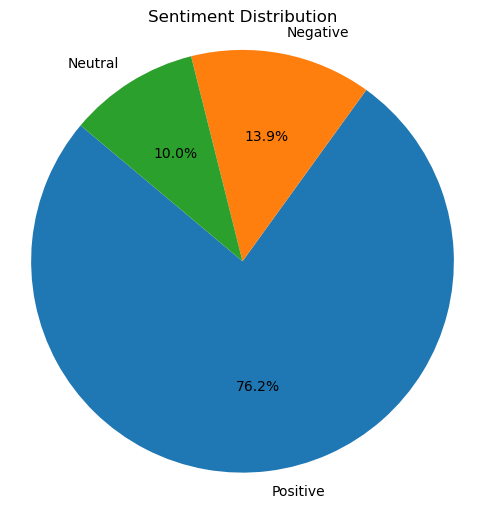

In [24]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'sentiment_label' and calculate the count of each label
sentiment_counts = df['sentiment_label'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()
